In [1]:
# libabries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpful_functions import MLFunctions

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col=['date'], 
                    parse_dates=['date'],
                    date_format="%d.%m.%Y")

In [3]:
sales = sales.sort_index()
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()
sales['time'] = arr

In [4]:
date_shop_sum = sales.groupby(['date','shop_id']).sum()[['item_cnt_day']]
date_shop_count = sales.groupby(['date','shop_id']).nunique()[['item_id']]
date_shop_mean = sales.groupby(['date','shop_id']).mean()[['item_price']]
date_shop_median = sales.groupby(['date','shop_id']).median()[['time']]
sales_agg = pd.concat([date_shop_sum, date_shop_count, date_shop_mean, date_shop_median], axis=1)

In [5]:
sales_agg = sales_agg.reset_index()
sales_agg.index = sales_agg['date']

<Axes: xlabel='time'>

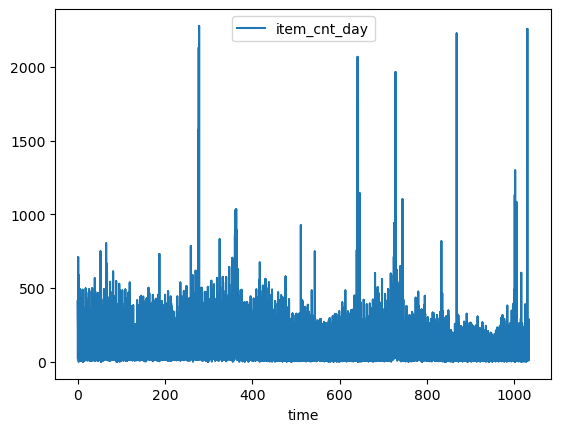

In [6]:
sales_agg.plot(kind='line', x='time', y='item_cnt_day')

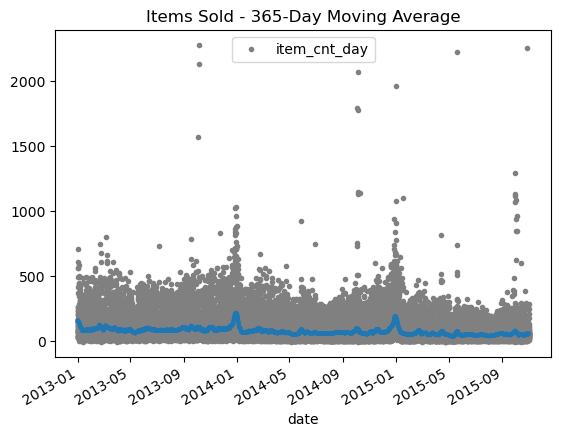

In [14]:
moving_average = sales_agg[['item_cnt_day']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales_agg[['item_cnt_day']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Items Sold - 365-Day Moving Average", legend=False,
);

<Axes: xlabel='time'>

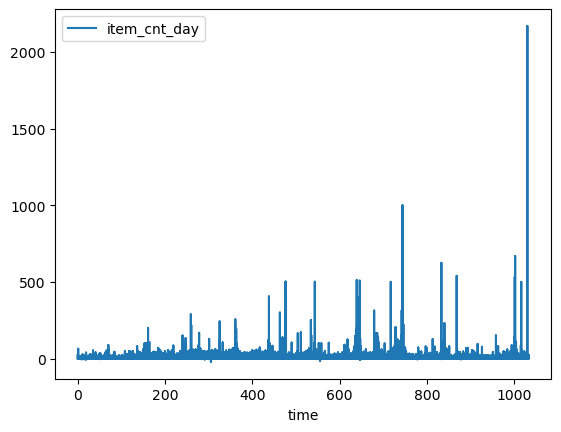

In [9]:
sales.plot(kind='line', x='time', y='item_cnt_day')

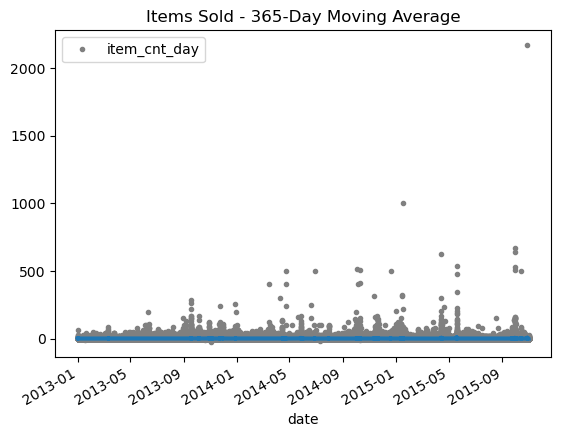

In [10]:
moving_average = sales[['item_cnt_day']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales[['item_cnt_day']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Items Sold - 365-Day Moving Average", legend=False,
);

<Axes: xlabel='time'>

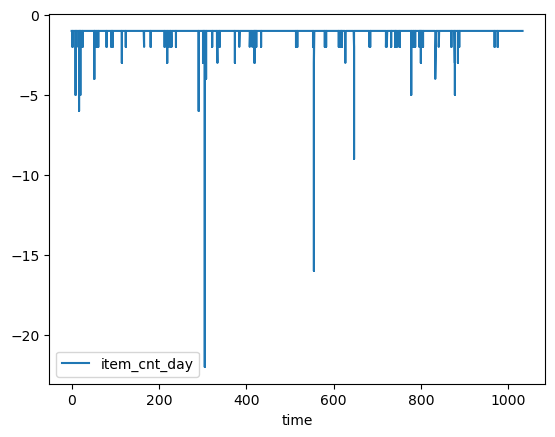

In [11]:
sales.loc[sales['item_cnt_day']<0, :].plot(x='time', y='item_cnt_day')